In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

In [2]:
def collect_data():
  
    data = pd.DataFrame({
        'route_distance': np.random.uniform(50, 500, 1000),
        'fuel_usage': np.random.uniform(10, 50, 1000),
        'traffic_index': np.random.uniform(0.5, 1.5, 1000),
        'weather_severity': np.random.uniform(0, 1, 1000),
        'cargo_weight': np.random.uniform(500, 20000, 1000),
        'carbon_emission': np.random.uniform(100, 1000, 1000)
    })
    return data


data = collect_data()
print(data.head())

   route_distance  fuel_usage  traffic_index  weather_severity  cargo_weight  \
0      436.792125   27.574502       1.222702          0.821235   8976.467264   
1       94.033507   31.174361       0.798152          0.388475   3544.561702   
2      449.033691   43.504223       0.727062          0.343403   4638.857398   
3      275.148639   31.902440       0.877983          0.001204   6726.951935   
4      148.121409   38.620925       0.648735          0.828230   8679.272846   

   carbon_emission  
0       361.063052  
1       949.030418  
2       832.714527  
3       441.831934  
4       592.327794  


In [3]:
def preprocess_data(data):
    
    data = data.fillna(data.mean())
    scaler = StandardScaler()
    features = data.drop('carbon_emission', axis=1)
    target = data['carbon_emission']
    features_scaled = scaler.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
print(f'Training set size: {X_train.shape}, Test set size: {X_test.shape}')

Training set size: (800, 5), Test set size: (200, 5)


In [16]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Add

# Step 1: Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Residual Block
def residual_block(x, units, dropout_rate=0.3):
    shortcut = x
    x = Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    return x

# Step 2: Define model
inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Adding residual blocks
x = residual_block(x, 128)
x = residual_block(x, 128)

x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

outputs = Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Step 3: Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mae',
    metrics=['mae']
)

# Step 4: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Step 5: Train
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, tensorboard],
    verbose=1
)

# Step 6: Evaluate
model.load_weights('best_model.keras')
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {test_mae}")


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 567.6903 - mae: 561.8995 - val_loss: 530.7495 - val_mae: 524.9962 - learning_rate: 5.0000e-04
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 547.5201 - mae: 541.7791 - val_loss: 530.5873 - val_mae: 524.8832 - learning_rate: 5.0000e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 568.9889 - mae: 563.2969 - val_loss: 530.4764 - val_mae: 524.8208 - learning_rate: 5.0000e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 556.5350 - mae: 550.8914 - val_loss: 530.3730 - val_mae: 524.7653 - learning_rate: 5.0000e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 568.6598 - mae: 563.0637 - val_loss: 530.2316 - val_mae: 524.6702 - learning_rate: 5.0000e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 558.4377 - mae: 552.8877 - val_loss: 530.0184 - val_mae: 524.5028 - learning_rate: 5.0000e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 545.7857 - mae: 

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 1.5996 - mae: 1.4949 - val_loss: 0.9208 - val_mae: 0.8161 - learning_rate: 5.0000e-04
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3753 - mae: 1.2707 - val_loss: 0.8520 - val_mae: 0.7474 - learning_rate: 5.0000e-04
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2653 - mae: 1.1607 - val_loss: 0.8156 - val_mae: 0.7111 - learning_rate: 5.0000e-04
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1728 - mae: 1.0684 - val_loss: 0.8184 - val_mae: 0.7140 - learning_rate: 5.0000e-04
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1178 - mae: 1.0135 - val_loss: 0.8298 - val_mae: 0.7255 - learning_rate: 5.0000e-04
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1250 - mae: 1.0208 - val_loss: 0.8479 - val_mae: 0.7438 - learning_rate: 5.0000e-04
Epoch 7/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0053 - mae: 0.9012
Epoch 7: ReduceLROnPlateau reducing learnin

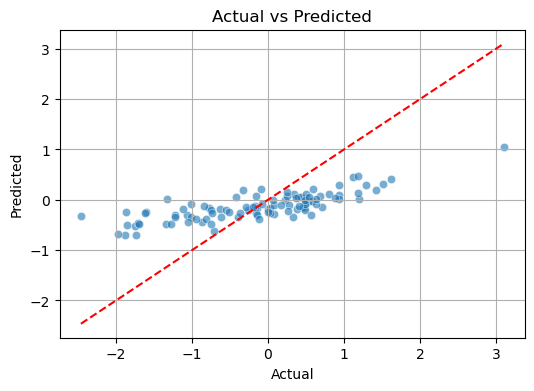

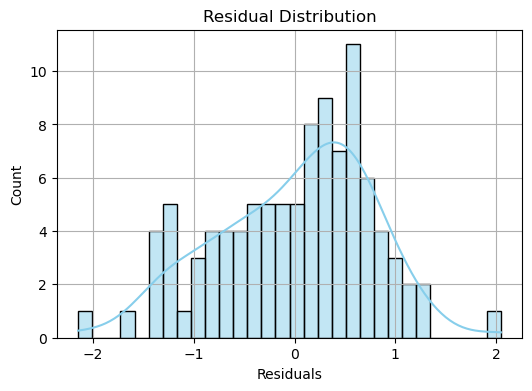

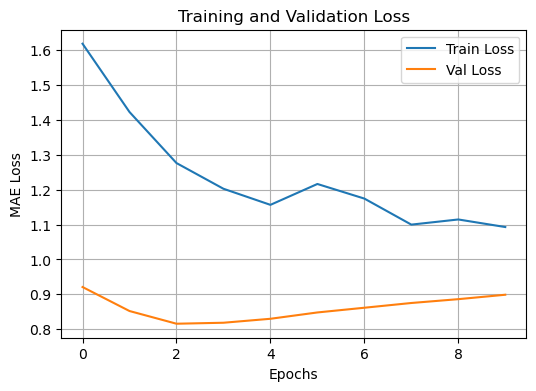

Final MAE on original scale: 91.16


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks

# Dummy data generation (replace with your actual data)
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=500, n_features=10, noise=10, random_state=42)
# Split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_model(input_shape):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='mae',
        metrics=['mae']
    )
    return model

def evaluate_model(model, X_test, y_test, history=None):
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f'📌 Evaluation Metrics:')
    print(f'   - MAE: {mae:.2f}')
    print(f'   - RMSE: {rmse:.2f}')
    print(f'   - R2 Score: {r2:.2f}')
    print(f'   - MAPE: {mape:.2f}%')
    
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_test.flatten(), y=predictions.flatten(), alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()
    
    residuals = y_test.flatten() - predictions.flatten()
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, bins=30, kde=True, color='skyblue')
    plt.title('Residual Distribution')
    plt.xlabel('Residuals')
    plt.grid(True)
    plt.show()
    
    if history:
        plt.figure(figsize=(6,4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('MAE Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    return predictions

# Data scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Fix: Convert y_train and y_test to numpy arrays before reshaping
y_train_scaled = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler_y.transform(np.array(y_test).reshape(-1, 1))

model = build_model(input_shape=X_train_scaled.shape[1])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
checkpoint = callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
tensorboard_cb = callbacks.TensorBoard(log_dir='./logs')

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr, checkpoint, tensorboard_cb],
    verbose=1
)

# Predict and inverse transform predictions to original scale
predictions_scaled = evaluate_model(model, X_test_scaled, y_test_scaled, history=history)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Final evaluation on unscaled data
final_mae = mean_absolute_error(y_test, predictions)
print(f'Final MAE on original scale: {final_mae:.2f}')


In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, regularizers, callbacks

# Define the scaler and model globally to be used across functions
scaler = StandardScaler()

# Build Model
def build_model(input_shape):
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='mae',
                  metrics=['mae'])
    return model

# Initialize the model with the correct input shape
model = build_model(input_shape=(5,))

# Simulated training (this should be replaced with your actual training logic)
X_train = np.random.rand(100, 5)
y_train = np.random.rand(100, 1)

X_train_scaled = scaler.fit_transform(X_train)
model.fit(X_train_scaled, y_train, epochs=10, batch_size=16)

# Route Suggestion Logic
def suggest_optimal_route(route_data):
    """
    Suggests the optimal route based on carbon emission estimates.
    
    Parameters:
    - route_data (pd.DataFrame): DataFrame containing route features.
    
    Returns:
    - list: List of predicted carbon emissions for each route.
    """
    expected_columns = ['route_distance', 'fuel_usage', 'traffic_index', 'weather_severity', 'cargo_weight']
    
    # Ensure all expected columns are present
    if not all(col in route_data.columns for col in expected_columns):
        raise ValueError(f"Input data must contain the following columns: {expected_columns}")
    
    # Ensure the scaler is loaded
    if 'scaler' not in globals():
        raise ValueError("Scaler not found. Please ensure the scaler is loaded before predictions.")
    
    # Select only the expected columns and scale the data
    processed_data = scaler.transform(route_data[expected_columns].values)

    # Debugging: Check shapes
    print(f"Processed Data Shape: {processed_data.shape}")
    print(f"Model Input Shape: {model.input_shape}")

    # Ensure the input shape matches the model's expectation
    if processed_data.shape[1] != model.input_shape[1]:
        raise ValueError(f"Model expected {model.input_shape[1]} features, but got {processed_data.shape[1]}.")
    
    # Predict emissions
    predicted_emissions = model.predict(processed_data)

    # Output the predictions
    for idx, emission in enumerate(predicted_emissions):
        print(f"🚀 Suggested Route {idx + 1} Carbon Emission Estimate: {emission[0]:.2f} kg")

    return predicted_emissions.flatten().tolist()

# Example Usage
sample_route = pd.DataFrame([
    [300, 20, 1.2, 0.5, 15000],
    [400, 25, 1.5, 0.7, 18000]
], columns=['route_distance', 'fuel_usage', 'traffic_index', 'weather_severity', 'cargo_weight'])

suggest_optimal_route(sample_route)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.2243 - mae: 1.1296
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2119 - mae: 1.1172
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2324 - mae: 1.1378 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2184 - mae: 1.1238 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1836 - mae: 1.0890 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1707 - mae: 1.0761 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2422 - mae: 1.1477 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1257 - mae: 1.0312 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0170 - mae: 0.9225 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9890 - mae: 0.8945 
Processed Data Shape: (2, 5)
Model Input Shape: (None, 5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
🚀 Suggested Route 1 Carbon Emission Estimate: -77.91 kg
🚀 Suggested Route 2 Carbon Emission Estimate: -68.85 kg


[-77.91044616699219, -68.85209655761719]

In [38]:
import tensorflow as tf
model = tf.keras.models.load_model('best_model.keras')
print(model.summary())


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,725 (120.02 KB)

 Trainable params: 10,113 (39.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 20,228 (79.02 KB)

None
